# 1. 背景与挖掘目标

- 项目为《Python 数据分析与挖掘实战》第 14 章：基于基站定位数据的商圈分析。内容参考了书中源代码，由于随书资料里只有经过部分处理的数据，因此对于属性构造部分省略，主要为聚类算法部分内容。
- 挖掘目标为对基站分群，分析不同群体的特征，比较不同商圈类别的价值。

# 2. 分析方法与过程

## 2.1 数据预处理

- 由于各个属性之间的数据差异较大，为了消除数量级的影响，需要进行离差标准化，对原始数据的线性变换，使结果落到 [0,1] 区间

In [6]:
'''读取数据'''
import pandas as pd
import numpy as np

inputfile = 'chapter14/demo/data/business_circle.xls'
data = pd.read_excel(inputfile, index_col='基站编号')
data.head()

,工作日上班时间人均停留时间,凌晨人均停留时间,周末人均停留时间,日均人流量
基站编号,,,,
36902,78,521,602,2863
36903,144,600,521,2245
36904,95,457,468,1283
36905,69,596,695,1054
36906,190,527,691,2051


In [7]:
'''离差标准化'''
stdfile = 'chapter14/demo/tmp/std.xls'    # 输出文件路径
data = (data - data.min()) / (data.max() - data.min())
data.reset_index(inplace=True)
data.to_excel(stdfile, index=False)
data.head()

,基站编号,工作日上班时间人均停留时间,凌晨人均停留时间,周末人均停留时间,日均人流量
0,36902,0.103865,0.856364,0.850539,0.169153
1,36903,0.263285,1.000000,0.725732,0.118210
2,36904,0.144928,0.740000,0.644068,0.038909
3,36905,0.082126,0.992727,0.993837,0.020031
4,36906,0.374396,0.867273,0.987673,0.102217


## 2.2 模型构建

1. 采用层次聚类算法对数据进行聚类，并画出谱系聚类图。可以看到我们可以将聚类类别数取 3 类

<IPython.core.display.Javascript object>


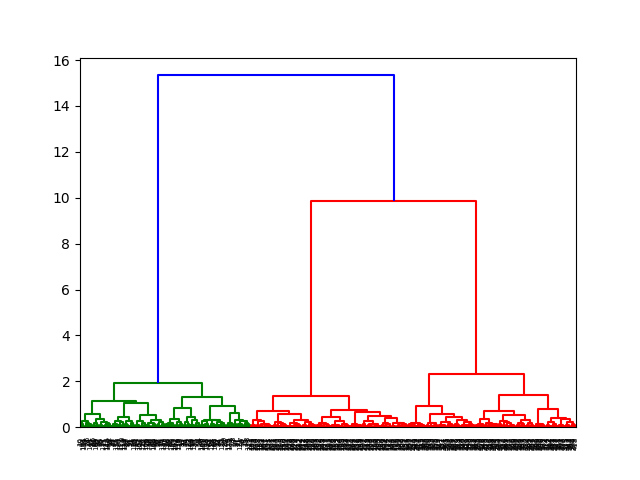

In [11]:
'''谱系聚类图'''
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
%matplotlib notebook

data = data.set_index('基站编号')
Z = linkage(data, method='ward', metric='euclidean')    # 谱系聚类图
P = dendrogram(Z, 0)    # 绘图

2. 聚类并输出原始序列及其类别

In [12]:
'''层次聚类'''
k = 3    # 聚类数

from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=k, linkage='ward')
model.fit(data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3,
                        pooling_func='deprecated')

In [13]:
# 详细输出原始序列及其类别
r = pd.concat([data, pd.Series(model.labels_, index=data.index)], axis=1)
r.columns = list(data.columns) + ['聚类类别']

3. 模型分析：类别 1 日均人流量高，人均停留时间均较低，推测该区域为商业区。类别 2 凌晨和周末人均停留时间长，工作日人均停留时间短，人流量小，推测该区域为住宅区。类别 3 工作日人均停留时间长，凌晨和周末人均停留时间短，人流量小，推测该区域为写字楼等工作区域。

<IPython.core.display.Javascript object>


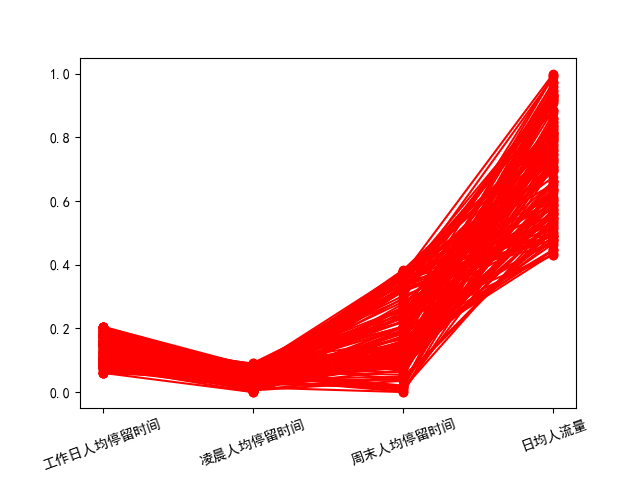

<IPython.core.display.Javascript object>


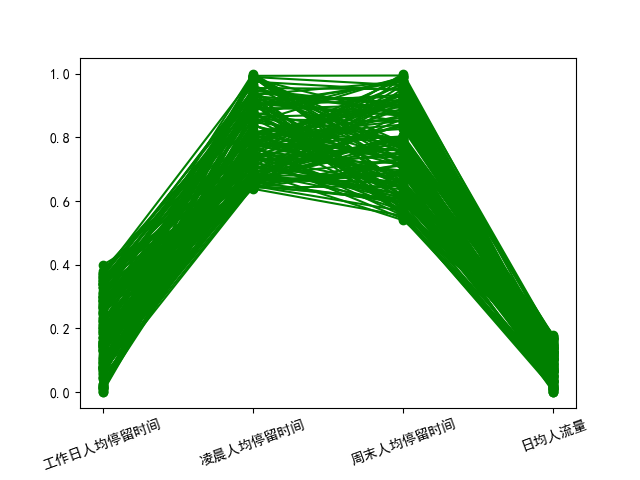

<IPython.core.display.Javascript object>


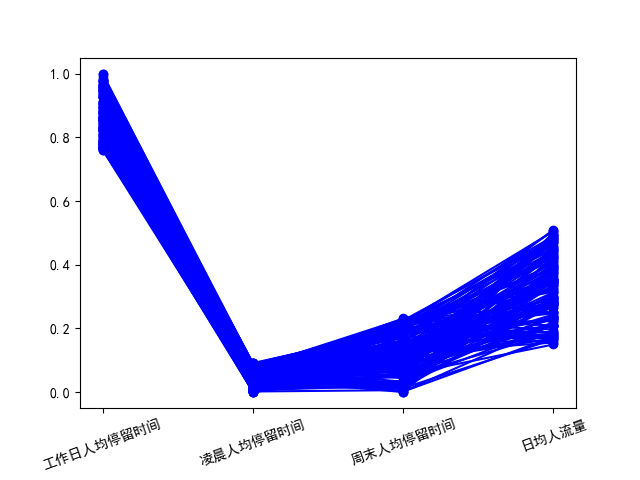

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

style = ['ro-', 'go-', 'bo-']
xlabels = ['工作日人均停留时间', '凌晨人均停留时间', '周末人均停留时间', '日均人流量']
pic_output = 'chapter14/demo/tmp/type_'    # 聚类图文件名前缀

for i in range(k):
    plt.figure()
    tmp = r[r['聚类类别'] == i].iloc[:, :4]
    for j in range(len(tmp)):
        plt.plot(range(1, 5), tmp.iloc[j], style[i])
    
    plt.xticks(range(1, 5), xlabels, rotation=20)
    plt.subplots_adjust(bottom=0.15)
    plt.savefig('%s%s.png' % (pic_output, i))